In [1]:
base_path = '/home/datasets/rsna-intracranial-hemorrhage-detection/'
csv_path = base_path + 'stage_2_train.csv'
items = base_path + 'stage_2_train/'
from torch.utils.data import Dataset, DataLoader
import torch, csv, pydicom
import torchvision.transforms as transforms
from PIL import Image
class RSNASet(Dataset):
    def __init__(self, csv_path, root_dir):
        self.root_dir = root_dir
        labels = {}
        with open(csv_path) as f:
            rdr = csv.reader(f)
            next(rdr)
            for rows in rdr:
                fn = '_'.join(rows[0].split('_')[0:2])
                try:
                    labels[fn].append(int(rows[1]))
                except:
                    labels[fn] = [int(rows[1])]
        for fn in labels.keys():
            # "any" should really be the classification "none"
            # so, it should only be 1 if nothing else is true - swap the values
            labels[fn][5] = abs(labels[fn][5]-1)
        self.labels = labels
        self.files = list(labels.keys())
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        file = self.files[idx]
        label = torch.argmax(torch.FloatTensor(self.labels[file]))
        img = pydicom.dcmread(self.root_dir+file+'.dcm').pixel_array
        tf = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256)),
            transforms.Lambda(lambda x: x.repeat(3,1,1)),
            transforms.ConvertImageDtype(torch.float),
        ])
        img = tf(Image.fromarray(img))
        return img, label
valset = RSNASet(csv_path=csv_path, root_dir=items)
classes = ('epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural','none')

In [2]:
root_dir = items
labels = {}
with open(csv_path) as f:
    rdr = csv.reader(f)
    next(rdr)
    for rows in rdr:
        fn = '_'.join(rows[0].split('_')[0:2])
        try:
            labels[fn].append(int(rows[1]))
        except:
            labels[fn] = [int(rows[1])]
for fn in labels.keys():
    # "any" should really be the classification "none"
    # so, it should only be 1 if nothing else is true - swap the values
    labels[fn][5] = abs(labels[fn][5]-1)
files_global = list(labels.keys())

In [3]:
import torch, glob
from tqdm import tqdm
import torch.nn.functional as F
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=len(classes))
if not torch.cuda.is_available():
    model.load_state_dict(torch.load('weights/split_resnet18/epoch40.pth', map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load('weights/split_resnet18/epoch40.pth'))
model.eval()
if torch.cuda.is_available():
    print("CUDA is available - using CUDA!")
    model = model.cuda()
running_loss = 0.0
batch = 0
total_correct = 0
total = 0

Using cache found in /home/dsingh/.cache/torch/hub/pytorch_vision_v0.10.0


In [4]:
arr = []
not_5 = []
for i, item in enumerate(valset):
    path = files_global[i]
    label = item[1]
    thing = item[0]
    if torch.cuda.is_available():
        label = label.cuda()
        thing = thing.cuda()
    outputs = model(thing.unsqueeze(0))
    predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
    if label != 5:
        not_5.append([path, item, label, predictions])
    arr.append([path, item, label, predictions])
    if len(arr) >= 20 and len(not_5) >= 20:
        break
    if i > 100:
        break

predicted: subdural label: subdural


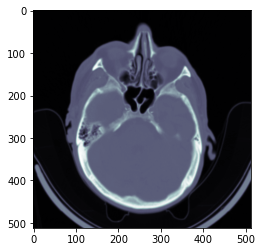

predicted: intraparenchymal label: intraparenchymal


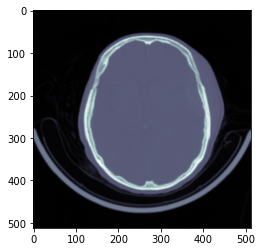

predicted: intraparenchymal label: intraparenchymal


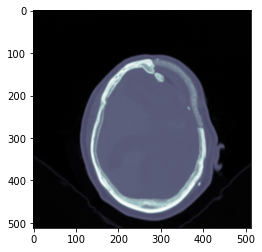

predicted: subarachnoid label: subarachnoid


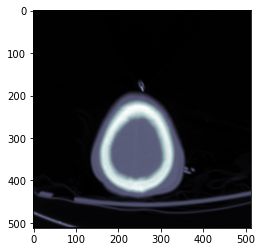

In [5]:
import matplotlib.pyplot as plt
for item in not_5:
    path, item, label, predictions = item
    if label != predictions:
        continue
    img = pydicom.dcmread(root_dir+path+'.dcm').pixel_array
    print("predicted:", classes[predictions.item()], "label:", classes[label.item()])
    plt.imshow(img, cmap=plt.cm.bone)  # set the color map to bone
    plt.show()
    input("Press enter to continue: ")


(512, 512)
predicted: none label: none


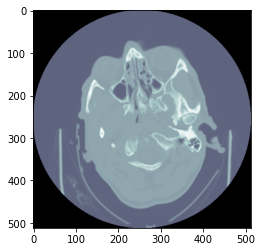

(512, 512)
predicted: none label: none


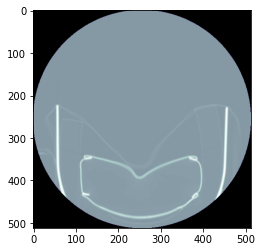

(512, 512)
predicted: none label: none


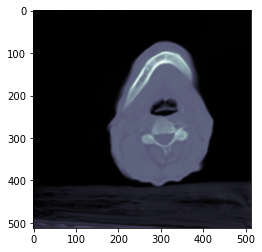

(512, 512)
predicted: none label: subarachnoid


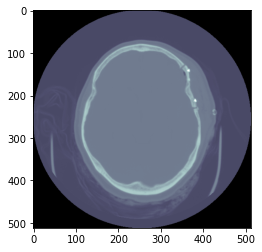

(512, 512)
predicted: none label: none


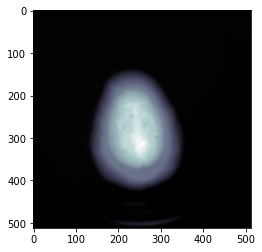

(512, 512)
predicted: none label: none


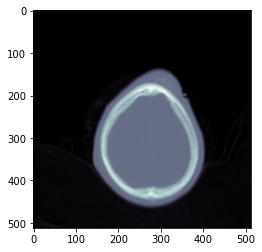

(512, 512)
predicted: none label: none


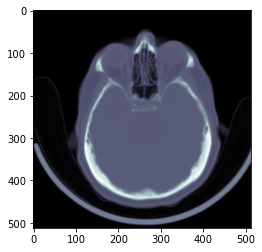

(512, 512)
predicted: none label: none


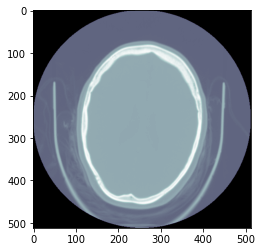

(512, 512)
predicted: none label: none


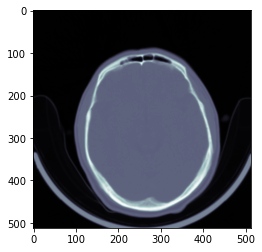

(512, 512)
predicted: none label: subarachnoid


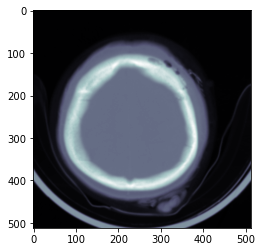

(512, 512)
predicted: none label: none


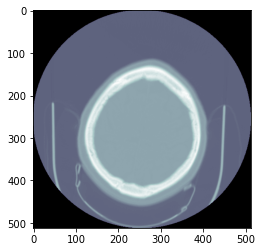

(512, 512)
predicted: none label: none


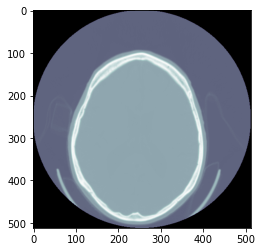

(512, 512)
predicted: none label: none


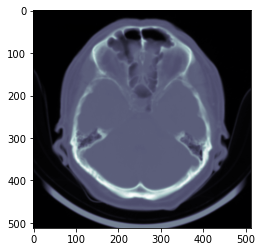

(512, 512)
predicted: none label: none


KeyboardInterrupt: 

In [7]:
import matplotlib.pyplot as plt
for item in arr:
    path, item, label, predictions = item
    img = pydicom.dcmread(root_dir+path+'.dcm').pixel_array
    print("predicted:", classes[predictions.item()], "label:", classes[label.item()])
    plt.imshow(img, cmap=plt.cm.bone)  # set the color map to bone
    plt.show()

In [ ]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
BATCH_SIZE = 128
criterion = torch.nn.CrossEntropyLoss()

base_path = '/home/datasets/rsna-intracranial-hemorrhage-detection/'
items = base_path + 'stage_2_test/'
dcms = glob.glob('{}*.dcm'.format(items))
testset = RSNATestSet(files=dcms, root_dir=items)
testloader = torch.utils.data.DataLoader(testset,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
classes = ('epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'none')
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False, num_classes=len(classes))
if not torch.cuda.is_available():
    model.load_state_dict(torch.load('weights/split_resnet18/epoch40.pth', map_location=torch.device('cpu')))
else:
    model.load_state_dict(torch.load('weights/split_resnet18/epoch40.pth'))
model.eval()
if torch.cuda.is_available():
    print("CUDA is available - using CUDA!")
    model = model.cuda()
running_loss = 0.0
batch = 0
total_correct = 0
total = 0
with tqdm(valloader, unit="batch") as tepoch:
        model.eval()
        for inputs, labels in tepoch:
            tepoch.set_description(f"Validating")
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            outputs = F.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1, keepdim=True).squeeze()
            correct = (predictions == labels).sum().item()
            total_correct += correct
            total += BATCH_SIZE
            accuracy = total_correct / total # batch_size
            running_loss += loss.item()
            if batch > 0:
                tepoch.set_postfix(loss=running_loss/batch, accuracy=100. * accuracy)
            batch += 1